In [6]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy

# Set DeepXDE backend, we could use tensorflow, jax or paddle instead
os.environ['DDE_BACKEND'] = 'pytorch'

import deepxde as dde

# Increasing floating point precision
dde.config.set_default_float('float64')

# For experiments reproductibility
dde.config.set_random_seed(42)

Set the default float type to float64


## Verhulst model

The Verhulst model is defined as

\begin{eqnarray*}
\frac{d p(t)}{dt} &=& \left(a - b p(t)\right)p(t), \quad \forall \, t > t_0, \\
p(t_0) &=& p_0,
\end{eqnarray*}

whose exact solution is given by

\begin{equation*}
  p(t) = \frac{a p_0}{bp_0 + (a - bp_0)e^{-(t - t_0)}}.
\end{equation*}

We solve this problem in the time interval $[0, 10]$, so that $t_0 = 0$. Furthermore, we consider  

$$
a = 1.0, \quad b = 0.1, \quad p_0 \in \{0.1, 20\}.
$$

In [34]:
p0 = 12
a = 1.0
b = 0.1
t0, tf = 0, 10

In [35]:
def known_solution(t):
    return (a * p0) / (b * p0 + (a - b * p0) * np.exp(-(t - t0)))

In [36]:

geom = dde.geometry.TimeDomain(t0, tf)

def ode(t, p):
    dp_dt = dde.grad.jacobian(p, t, i=0, j=0)
    return dp_dt - ((a - b * p) * p)

ic = dde.icbc.IC(
    geom, 
    lambda x: np.ones(x.shape) * p0, 
    lambda _, on_initial: on_initial,
    component=0)

n_domain = 50
n_bound = 2
n_test = 20

data = dde.data.PDE(geom, ode, ic, num_domain=n_domain, num_boundary=n_bound, solution=known_solution, num_test=n_test)

neurons = 50
layers = 3
layer_size = [1] + [neurons] * layers + [1]
activation = "tanh"
initializer = "Glorot uniform"
optimizer = "adam"
learning_rate = 0.001

net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)

model.compile(optimizer, lr=learning_rate, metrics=["l2 relative error"])


Compiling model...
'compile' took 0.000146 s



Training model...

Step      Train loss              Test loss               Test metric   
0         [1.92e-01, 1.44e+02]    [1.99e-01, 1.44e+02]    [1.04e+00]    
1000      [1.57e-02, 2.22e-04]    [7.76e-03, 2.22e-04]    [4.90e-03]    
2000      [1.82e-03, 4.66e-06]    [8.65e-04, 4.66e-06]    [1.87e-03]    
3000      [6.51e-04, 4.59e-07]    [3.96e-04, 4.59e-07]    [1.05e-03]    
4000      [3.48e-04, 1.30e-07]    [2.25e-04, 1.30e-07]    [7.48e-04]    
5000      [1.49e-04, 3.36e-08]    [9.70e-05, 3.36e-08]    [4.97e-04]    
6000      [4.43e-05, 5.20e-09]    [2.97e-05, 5.20e-09]    [2.86e-04]    
7000      [1.10e-05, 5.78e-10]    [6.52e-06, 5.78e-10]    [1.42e-04]    
8000      [5.42e-06, 9.45e-11]    [2.96e-06, 9.45e-11]    [9.06e-05]    
9000      [3.71e-06, 4.25e-11]    [1.91e-06, 4.25e-11]    [6.92e-05]    
10000     [2.56e-06, 2.71e-11]    [1.23e-06, 2.71e-11]    [5.36e-05]    
11000     [1.69e-06, 1.44e-11]    [8.22e-07, 1.44e-11]    [4.29e-05]    
12000     [1.13e-06, 5.79e-12]  

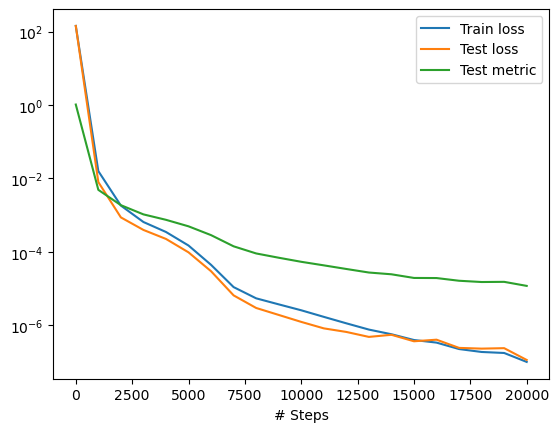

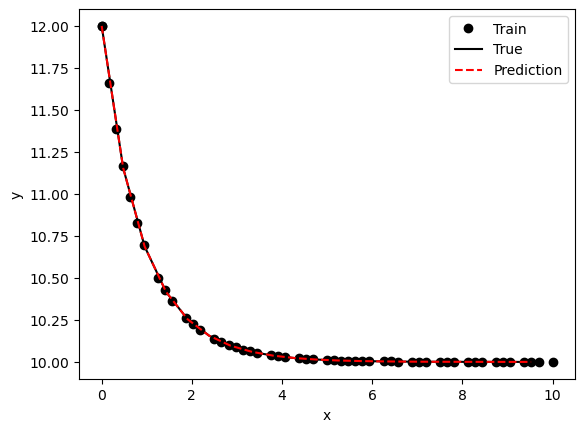

In [37]:
losshistory, train_state = model.train(iterations=20000, model_save_path="../models/verhulst")

dde.saveplot(losshistory, train_state, isplot=True, issave=False)


In [ ]:
# Restoring model
model.restore("../models/verhulst-20000.pt")

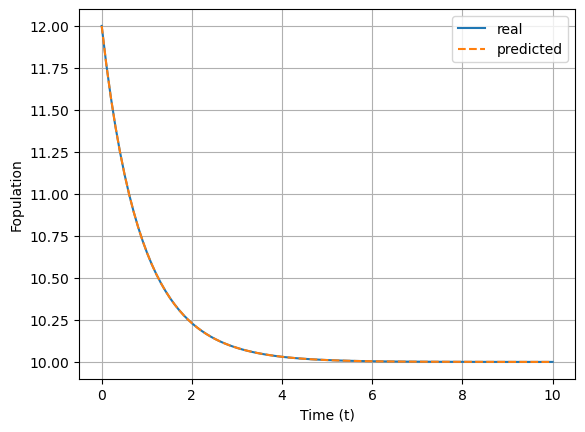

In [38]:
# Plot predicted values against reference solution
nop = 100
T = np.linspace(t0, tf, nop)

pred = model.predict(T.reshape(-1, 1))
real = known_solution(T.reshape(-1, 1))

plt.plot(T, real, label="real")
plt.plot(T, pred, "--", label="predicted")

plt.xlabel("Time (t)")
plt.ylabel("Fopulation")
plt.legend()
plt.grid()
plt.savefig("../figures/verhulst.png")
plt.show()